In [1]:
import numpy as np 
import pandas as pd 
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
%matplotlib inline


C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
amazon_review=pd.read_csv("Clothing_Shoes_and_Jewelry.csv",names=['userId', 'productId','Rating','timestamp'])


In [3]:
amazon_review.head()


,userId,productId,Rating,timestamp
0,0871167042,A2IC3NZN488KWK,5.0,1399161600
1,0871167042,A3OT9BYASFGU2X,4.0,1398470400
2,0871167042,A28GK1G2KDXHRP,5.0,1397692800
3,0871167042,A3NFXFEKW8OK0E,5.0,1397606400
4,0871167042,A3I6G5TKBVJEK9,5.0,1397520000


In [4]:
amazon_review.shape

(32292099, 4)

In [5]:
amazon_review=amazon_review.iloc[:1048576,0:]

In [6]:
amazon_review.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [7]:
amazon_review.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
userId       1048576 non-null object
productId    1048576 non-null object
Rating       1048576 non-null float64
timestamp    1048576 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [8]:
amazon_review.describe()['Rating'].T


count    1.048576e+06
mean     4.270940e+00
std      1.167311e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [10]:
print('Minimum rating is: %d' %(amazon_review.Rating.min()))
print('Maximum rating is: %d' %(amazon_review.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


The rating of the product range from 0 to 1

In [11]:
print('Number of missing values across columns: \n',amazon_review.isnull().sum())



Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


In [14]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",amazon_review.shape[0])
print("Total No of Users   :", len(np.unique(amazon_review.userId)))
print("Total No of products  :", len(np.unique(amazon_review.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 1048576
Total No of Users   : 6409
Total No of products  : 835359


In [15]:
amazon_review.drop(['timestamp'], axis=1,inplace=True)

In [16]:
no_of_rated_products_per_user = amazon_review.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
B00006XXGO    8266
B0007YR980    8100
B000E0Q5UU    7982
B000EDKSEG    7298
B000EDMSEE    7298
Name: Rating, dtype: int64

In [17]:
no_of_rated_products_per_user.describe()


count    6409.000000
mean      163.609924
std       470.846640
min         1.000000
25%         8.000000
50%        29.000000
75%       116.000000
max      8266.000000
Name: Rating, dtype: float64

In [18]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')


<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

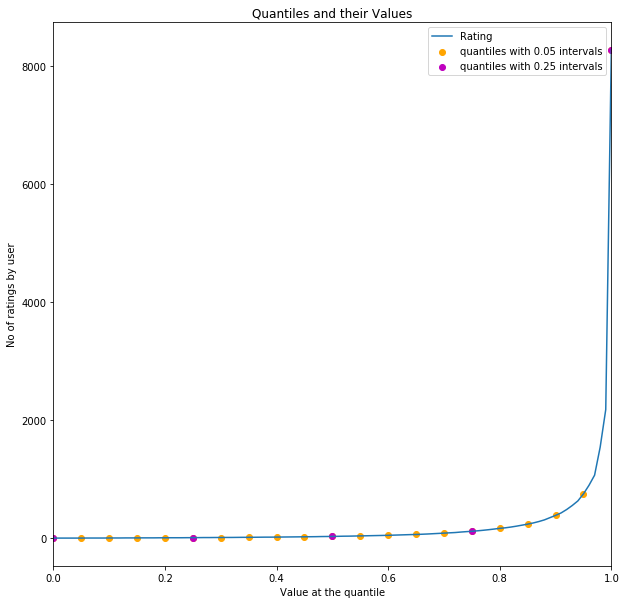

In [19]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [20]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )



 No of rated product more than 50 per user : 2532



In [34]:


new_df=amazon_review.groupby("productId").filter(lambda x:x['Rating'].count() >=10)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

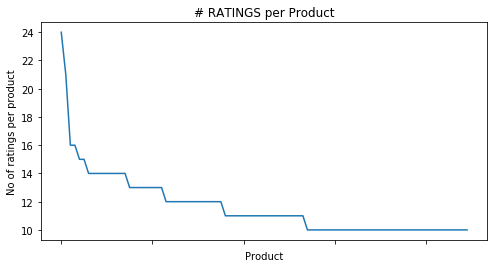

In [35]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [36]:
new_df.groupby('productId')['Rating'].mean().head()

productId
A117XUS2KI1M04    4.100000
A11GBTUGNRGCR8    5.000000
A14MYSLWJK4V0B    5.000000
A14T7F18U61SC     5.000000
A15MVKFSE4Y0DP    4.636364
Name: Rating, dtype: float64

In [37]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()


productId
A1XQ0F01CF84Y3    5.0
A2ZR1J2JC81B3B    5.0
A3FJ6M5OT3FLZE    5.0
A1GUV5FIQP1Z2Y    5.0
A1V1O00D80RXNH    5.0
Name: Rating, dtype: float64

In [38]:


new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
A1V1O00D80RXNH    24
A3W4D8XOGLWUN5    21
A1BKO977F72Y6F    16
A7SBWPBRLILX0     16
A24PK4Q70CS0N0    15
Name: Rating, dtype: int64

In [39]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())


In [40]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())


In [41]:
ratings_mean_count.head()


,Rating,rating_counts
productId,,
A117XUS2KI1M04,4.100000,10
A11GBTUGNRGCR8,5.000000,13
A14MYSLWJK4V0B,5.000000,10
A14T7F18U61SC,5.000000,10
A15MVKFSE4Y0DP,4.636364,11


In [42]:
ratings_mean_count['rating_counts'].max()


24

<Figure size 576x432 with 0 Axes>

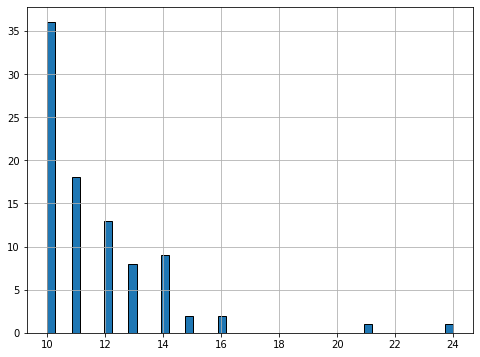

In [43]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

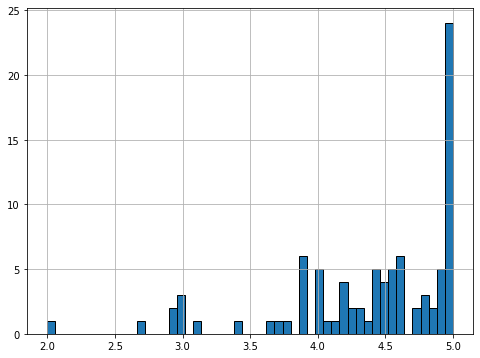

In [44]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

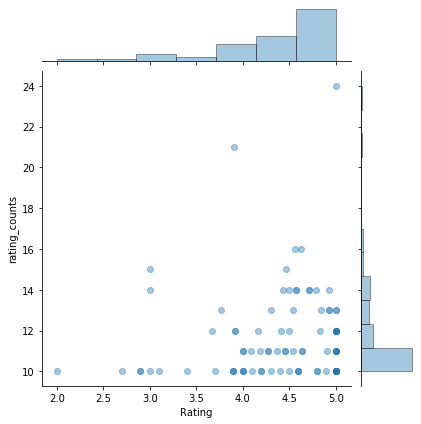

In [45]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

In [ ]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")